Train label counts: Counter({10: 105, 11: 58, 5: 35, 4: 34, 9: 33, 12: 31, 1: 30, 0: 26, 7: 22, 3: 14, 6: 10, 2: 8, 8: 6})
 Val  label counts: Counter({10: 27, 11: 14, 5: 9, 4: 8, 12: 8, 9: 8, 1: 8, 0: 7, 7: 6, 3: 3, 8: 2, 2: 2, 6: 2})
Epoch 01 | Train Loss: 2.3718, Acc: 0.3034 | Val   Loss: 2.2057, Acc: 0.5192
Epoch 02 | Train Loss: 1.8641, Acc: 0.7257 | Val   Loss: 1.5750, Acc: 0.7019
Epoch 03 | Train Loss: 1.3770, Acc: 0.8058 | Val   Loss: 1.1308, Acc: 0.7692
Epoch 04 | Train Loss: 1.0334, Acc: 0.8738 | Val   Loss: 0.8938, Acc: 0.8269
Epoch 05 | Train Loss: 0.7479, Acc: 0.9320 | Val   Loss: 0.6890, Acc: 0.8462
Epoch 06 | Train Loss: 0.5587, Acc: 0.9175 | Val   Loss: 0.5458, Acc: 0.8654
Epoch 07 | Train Loss: 0.4202, Acc: 0.9369 | Val   Loss: 0.4598, Acc: 0.8846
Epoch 08 | Train Loss: 0.3282, Acc: 0.9539 | Val   Loss: 0.4116, Acc: 0.8942
Epoch 09 | Train Loss: 0.2587, Acc: 0.9684 | Val   Loss: 0.3738, Acc: 0.9038
Epoch 10 | Train Loss: 0.2078, Acc: 0.9806 | Val   Loss: 0.3579, Acc: 0

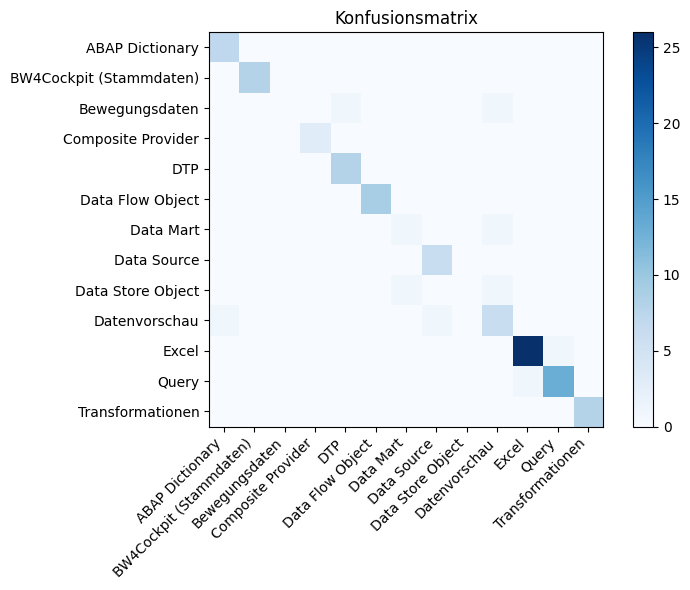

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter

# ————————————————————————————————
# 0) Device und pin_memory
# ————————————————————————————————
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_cuda = (device.type == "cuda")

# ————————————————————————————————
# 1) Pfade & Hyperparameter
# ————————————————————————————————
data_dir   = "/Users/berrecelik/Desktop/dataset/train"  # gelabelte Ordnerstruktur
val_frac   = 0.2
batch_size = 32
num_epochs = 15
lr         = 1e-4

# ————————————————————————————————
# 2) Daten-Transforms
# ————————————————————————————————
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# ————————————————————————————————
# 3) Komplettes Dataset laden + Stratified Split
# ————————————————————————————————
full_ds = datasets.ImageFolder(data_dir, transform=train_transform)
classes = full_ds.classes
y       = full_ds.targets

sss = StratifiedShuffleSplit(n_splits=1, test_size=val_frac, random_state=42)
train_idx, val_idx = next(sss.split(np.zeros(len(y)), y))

# Verteilungen prüfen (optional)
print("Train label counts:", Counter([y[i] for i in train_idx]))
print(" Val  label counts:", Counter([y[i] for i in val_idx]))

# Subsets erstellen und transforms setzen
train_ds = Subset(full_ds, train_idx)
val_ds   = Subset(full_ds, val_idx)
val_ds.dataset.transform = val_transform

# ————————————————————————————————
# 4) DataLoader
# ————————————————————————————————
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,
    num_workers=4, pin_memory=use_cuda
)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False,
    num_workers=2, pin_memory=use_cuda
)

# ————————————————————————————————
# 5) Modellaufbau: EfficientNet-B0
# ————————————————————————————————
weights = EfficientNet_B0_Weights.DEFAULT
model   = efficientnet_b0(weights=weights)
in_f    = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_f, len(classes))
model = model.to(device)

# ————————————————————————————————
# 6) Loss & Optimizer
# ————————————————————————————————
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# ————————————————————————————————
# 7) Trainingsschleife
# ————————————————————————————————
best_val_acc = 0.0
best_state  = None

for epoch in range(1, num_epochs+1):
    # —— Training —— 
    model.train()
    running_loss, running_correct, running_total = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss    += loss.item() * imgs.size(0)
        running_correct += (outputs.argmax(1)==labels).sum().item()
        running_total   += imgs.size(0)
    train_loss = running_loss / running_total
    train_acc  = running_correct / running_total

    # —— Validation —— 
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss    += loss.item() * imgs.size(0)
            preds        = outputs.argmax(1)
            val_correct += (preds==labels).sum().item()
            val_total   += imgs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_loss /= val_total
    val_acc  = val_correct / val_total

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state  = model.state_dict()

# Bestes Modell speichern
torch.save(best_state, "efficientnet_b0_best.pth")
print(f"Beste Val-Accuracy: {best_val_acc:.4f}")

# ————————————————————————————————
# 8) Finale Auswertung
# ————————————————————————————————
model.load_state_dict(best_state)
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        preds = model(imgs).argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("=== Classification Report ===")
print(classification_report(
    all_labels, all_preds,
    target_names=classes,
    zero_division=0
))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Konfusionsmatrix")
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45, ha="right")
plt.yticks(ticks, classes)
plt.tight_layout()
plt.show()


In [ ]:
# —————————————————————————————
# (Eğitim & validation bitti, en iyi ağırlık 'efficientnet_b0_best.pth' kaydedildi)
# —————————————————————————————

# 1) Inference transform
inf_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# 2) Karışık klasörü tek alt klasöre koymuş olduğunu varsayıyoruz:
#    /path/to/karisik/unknown/*.png
inf_data_dir   = "/Users/berrecelik/Desktop/dataset/val"  # gelabelte Ordnerstruktur

inf_ds = datasets.ImageFolder(inf_data_dir, transform=inf_transform)

# 3) DataLoader
inf_loader = DataLoader(
    inf_ds,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=use_cuda
)

# 4) Modeli yeniden oluştur, en iyi ağırlıkları yükle, eval moduna geçir
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(classes))
model.load_state_dict(torch.load("efficientnet_b0_best.pth"))
model.to(device)
model.eval()

# 5) Tahminleri topla
all_preds = []
with torch.no_grad():
    for imgs, _ in inf_loader:
        imgs = imgs.to(device, non_blocking=True)
        logits = model(imgs)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)

# 6) Dosya adları ve sınıf isimleri
all_filenames = [os.path.basename(path) for path, _ in inf_ds.samples]
idx2label = {v:k for k,v in inf_ds.class_to_idx.items()}
all_labels = [idx2label[p] for p in all_preds]

# 7) CSV’ye yaz
import pandas as pd
df = pd.DataFrame({
    "filename": all_filenames,
    "predicted_label": all_labels
})
df.to_csv("karisik_inference_3136.csv", index=False)
print("Inference sonuçları kaydedildi: karisik_inference_3136.csv")


FileNotFoundError: Couldn't find any class folder in /Users/berrecelik/Desktop/dataset/val/SAP.